## EXTRACION DE DATOS

In [ ]:
import kagglehub

# Download latest version
base_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", base_path)

c:\Users\SPARTAN PC\miniconda3\envs\langchain_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resuming download from 621805568 bytes (1841559867 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia?dataset_version_number=2 (621805568/2463365435) bytes left.


100%|██████████| 2.29G/2.29G [03:27<00:00, 8.87MB/s]

Extracting files...


Path to dataset files: C:\Users\SPARTAN PC\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [ ]:
# Use a raw string to avoid interpreting backslashes as escape sequences
base_path = r"C:\Users\SPARTAN PC\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"

## ESTRUCTURA DE LOS DIRECTORIOS

In [9]:
import os
for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Mostrar solo los primeros 3 archivos
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... y {len(files) - 3} archivos más')


2/
  chest_xray/
    test/
      NORMAL/
      PNEUMONIA/
    test_val/
      NORMAL/
        IM-0001-0001.jpeg
        IM-0003-0001.jpeg
        IM-0005-0001.jpeg
        ... y 239 archivos más
      PNEUMONIA/
        person100_bacteria_475.jpeg
        person100_bacteria_477.jpeg
        person100_bacteria_478.jpeg
        ... y 395 archivos más
    train/
      NORMAL/
        IM-0115-0001.jpeg
        IM-0117-0001.jpeg
        IM-0119-0001.jpeg
        ... y 1338 archivos más
      PNEUMONIA/
        person1000_bacteria_2931.jpeg
        person1000_virus_1681.jpeg
        person1001_bacteria_2932.jpeg
        ... y 3872 archivos más
    val/
      NORMAL/
      PNEUMONIA/
    __MACOSX/
      ._chest_xray
      chest_xray/
        ._.DS_Store
        ._test
        ._train
        test/
          ._.DS_Store
          ._NORMAL
          ._PNEUMONIA
          NORMAL/
            ._IM-0001-0001.jpeg
            ._IM-0003-0001.jpeg
            ._IM-0005-0001.jpeg
            ... y 231

In [12]:
path = os.path.join(base_path, "chest_xray")

### SEPARAMOS Y ANALISAMOS LA DISTRIBUCION DE IMAGENES

In [15]:
train_path = os.path.join(path, 'train')
test_val_path = os.path.join(path, 'test_val')

class_counts = {}
for split in ['train', 'test_val']:
    split_path = os.path.join(path, split)
    class_counts[split] = {}
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[split][class_name] = count

print("\n" + "=" * 50)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 50)
for split, classes in class_counts.items():
    print(f"\n{split.upper()}:")
    for class_name, count in classes.items():
        print(f"  {class_name}: {count} imágenes")


DISTRIBUCIÓN DE CLASES

TRAIN:
  NORMAL: 1341 imágenes
  PNEUMONIA: 3875 imágenes

TEST_VAL:
  NORMAL: 242 imágenes
  PNEUMONIA: 398 imágenes


In [16]:
import os
import shutil
import random


source = test_val_path

target_test_path = os.path.join(path, "test_new")
target_val_path = os.path.join(path, "val_new")
targets = [target_test_path, target_val_path]

os.makedirs(target_test_path, exist_ok=True)
os.makedirs(target_val_path, exist_ok=True)


## División del conjunto TEST_VAL

Tomé todas las imágenes del conjunto TEST_VAL y lo separé nuevamente en dos partes: un conjunto de prueba (*test*) y un conjunto de validación (*val*). Usé una proporción 80% para test y 20% para val porque es una división común cuando el conjunto de entrenamiento ya está definido.

La separación se hizo por clase, no mezclando todo. Así se mantiene la relación original entre NORMAL y PNEUMONIA en cada split.

Pasos:
1. Mezclé aleatoriamente las imágenes de cada clase.
2. Separé el 80% para test y el 20% para val.
3. Copié cada grupo en las carpetas nuevas `test_new/` y `val_new/`.

Esto deja dos conjuntos equilibrados y listos para evaluación y validación del modelo.


In [ ]:

for split in targets:
    os.makedirs(os.path.join(split, 'PNEUMONIA'), exist_ok=True) #esto crea la carpeta pneumonia
    os.makedirs(os.path.join(split, 'NORMAL'), exist_ok=True) #esto crea la carpeta normal

random.seed(1337)  # Fija la semilla para que la división sea reproducible

for class_name in ["NORMAL", "PNEUMONIA"]:
    class_path = os.path.join(source, class_name)
    files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    total = len(files)
    cut_off = int(0.8 * total)

    test_files = files[:cut_off]
    val_files = files[cut_off:]
    # mover
    for f in test_files:
        shutil.copy2(os.path.join(class_path, f),
                     os.path.join(target_test_path, class_name, f))
        
    for f in val_files:
        shutil.copy2(os.path.join(class_path, f),
                     os.path.join(target_val_path, class_name, f))
        
    print("Listo. Dividido en 80% test y 20% val.")



Aquí podemos ver que la distribución original del dataset se conserva: la proporción entre NORMAL y PNEUMONIA es prácticamente la misma en los nuevos conjuntos. Esto es importante porque mantiene la representación del problema tal como aparece en el mundo real.  

Además, ahora contamos con suficientes imágenes tanto en `VAL_NEW` como en `TEST_NEW`, lo que facilita evaluar el modelo de forma confiable y verificar que realmente generaliza.


In [18]:


class_counts = {}
for split in ['train', 'test_new', 'val_new']:
    split_path = os.path.join(path, split)
    class_counts[split] = {}
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[split][class_name] = count

print("\n" + "=" * 50)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 50)
for split, classes in class_counts.items():
    print(f"\n{split.upper()}:")
    for class_name, count in classes.items():
        print(f"  {class_name}: {count} imágenes")


DISTRIBUCIÓN DE CLASES

TRAIN:
  NORMAL: 1341 imágenes
  PNEUMONIA: 3875 imágenes

TEST_NEW:
  NORMAL: 193 imágenes
  PNEUMONIA: 318 imágenes

VAL_NEW:
  NORMAL: 49 imágenes
  PNEUMONIA: 80 imágenes


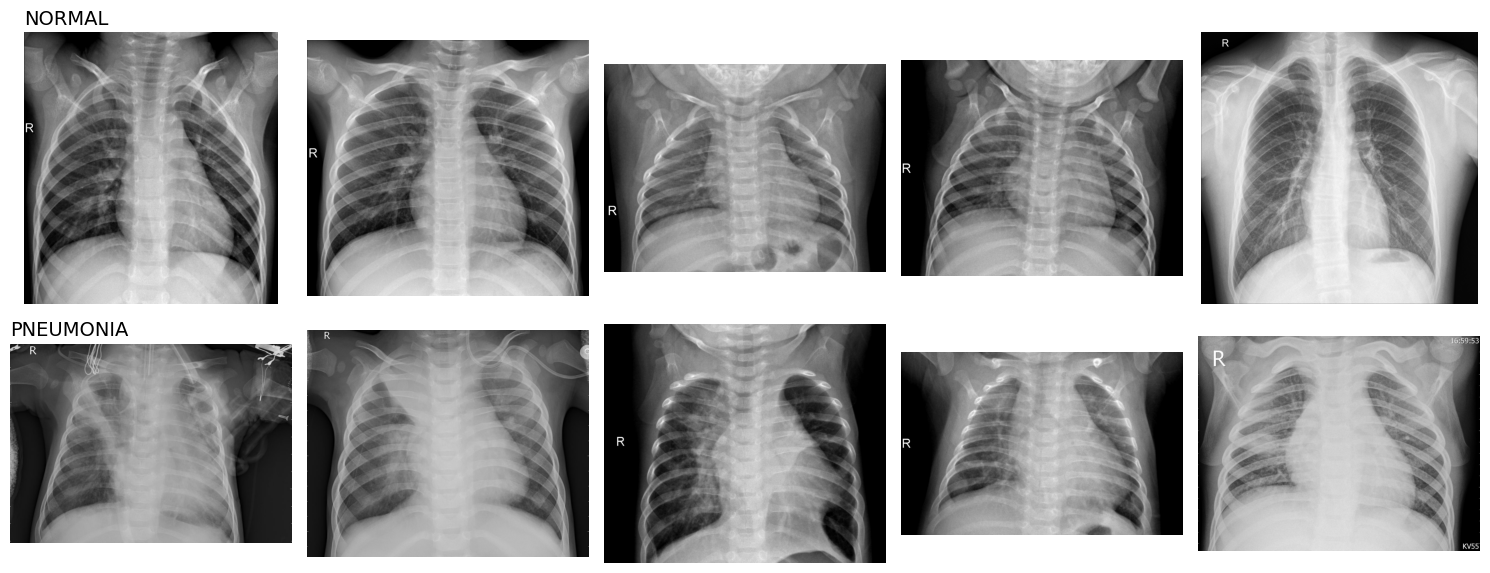

In [ ]:
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

train_dir = Path(os.path.join(path, 'train'))
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
n_per_class = 5

fig, axes = plt.subplots(len(classes), n_per_class,
                         figsize=(n_per_class * 3, len(classes) * 3))

axes = np.atleast_2d(axes)

for row, cls in enumerate(classes):
    class_dir = train_dir / cls
    files = [f for f in class_dir.iterdir()
             if f.suffix.lower() in ('.png', '.jpg', '.jpeg')]
    files = random.sample(files, min(len(files), n_per_class))

    for col in range(n_per_class):
        ax = axes[row, col]
        ax.axis("off")

        if col < len(files):
            img = Image.open(files[col]).convert("RGB")
            ax.imshow(img)

        # Poner el label SOLO en la primera columna de la fila
        if col == 0:
            ax.set_title(cls, fontsize=14, loc="left")

plt.tight_layout()
plt.show()


## 🔬 Justificación de la Estrategia de Balanceo

El *set* de entrenamiento presenta un **desbalance de clases significativo**, con una proporción de $2.9$ imágenes de **Pneumonía** por cada imagen de **Normal**. Dado el limitado número de imágenes, aplicaremos un **Pipeline Híbrido** para mitigar los riesgos de **sobreajuste** y **sesgo**.

---

### Estrategia de Mitigación

1.  **Data Augmentation Dinámico:**
    * **Finalidad:** Se aplica Aumento de Datos dinámico (*on-the-fly*) al *dataset* de entrenamiento. Esta técnica incrementa la **variedad** de la clase minoritaria (**Normal**), lo cual es crucial para prevenir el **sobreajuste** que podría ocurrir al contar con tan pocas imágenes originales en esa clase.

2.  **Ponderación de Clases:**
    * **Finalidad:** Se implementa Ponderación de Clases (*Class Weighting*) en la función de pérdida. Esta decisión es necesaria porque, a pesar de aplicar *Data Augmentation* a todo el *dataset*, el **sesgo de frecuencia** se mantiene en los *batches* de entrenamiento. La ponderación garantiza un aprendizaje más **equilibrado** al aumentar el peso de penalización por error en la clase **Normal**.

De esta manera, se ataca el desbalance desde el dominio de los datos (variedad) y desde el dominio algorítmico (importancia), sin la necesidad de reducir el tamaño del *dataset*.

# 1. Comenzamos el pipeline del entrenamiento creando los generadores para los diferentes sets


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Empezamos el pipeline definiendo los tamaños de imagen y el tamaño del batch
img_size = (180, 180)
batch = 32

In [26]:
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test_new')
val_path = os.path.join(path, 'val_new')

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Cargar datos

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    label_mode='binary',
    image_size=img_size,
    batch_size=batch,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    label_mode='binary',
    image_size=img_size,
    batch_size=batch,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    label_mode='binary',
    image_size=img_size,
    batch_size=batch,
    shuffle=False
)

Found 5216 files belonging to 2 classes.
Found 129 files belonging to 2 classes.
Found 511 files belonging to 2 classes.


prefetch hace que mientras el modelo entrena con un batch, el siguiente ya se esté cargando.

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


BLOQUE DE DATA AUGMENTANTION 

In [33]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
], name='data_augmentation')

In [34]:
model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),

    # Data augmentation dentro del modelo
    data_augmentation,

    # Normalización
    layers.Rescaling(1./255),

    # CNN
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,042,881 (11.61 MB)

 Trainable params: 3,042,881 (11.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 380ms/step - accuracy: 0.7759 - loss: 0.5030 - val_accuracy: 0.8450 - val_loss: 0.4054
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 513ms/step - accuracy: 0.8700 - loss: 0.3053 - val_accuracy: 0.6977 - val_loss: 0.5287
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9018 - loss: 0.2401 - val_accuracy: 0.6899 - val_loss: 0.7187
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.9258 - loss: 0.1917 - val_accuracy: 0.6589 - val_loss: 0.8756
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - accuracy: 0.9400 - loss: 0.1666 - val_accuracy: 0.8915 - val_loss: 0.2581
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 589ms/step - accuracy: 0.9413 - loss: 0.1648 - val_accuracy: 0.7597 - val_loss: 0.5307
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 922ms/step - accuracy: 0.9404 - loss: 0.1566 - val_accuracy: 0.8140 - val_loss: 0.6168
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 877ms/step - accuracy: 0.9446 - loss:

In [36]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7750 - loss: 0.7505
Test accuracy: 0.7749511003494263


## 1. Analisis del Modelo Primera version